# Multicriteria Spatial Analysis: Ideal areas for living in Cundinamarca    
# Part II

Programación SIG 2025-1S  
Universidad Nacional de Colombia  
Authors: Alicia Arévalo Robinson  
Link to repository: https://github.com/aliciaarevalor/SMCA

## Import libraries

In [13]:
import rasterio
import numpy as np
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt
from rasterio.features import rasterize
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.colors as mcolors
import geopandas as gpd
import sys
sys.path.append("C:/Users/VICTUS/Documents/MG/programacion_sig/SMCA/src")

from normalisation_functions import (
    normalise_slope_cost,
    normalise_proximity,
    normalise_proximity2,
    normalise_aqueduct_sewer,
    normalise_climate
)

## Load Raster Layers

This section loads all previously prepared raster layers that are aligned to the same extent, resolution and coordinate reference system (CRS). These layers will be used to evaluate suitability based on terrain, proximity, and legal constraints.

The rasters include:

- **Mean Temperature** (°C): Range data showing average temperature values.
- **Protected Areas**: Binary raster where protected zones are marked.
- **Mining Titles**: Binary raster where the presence of mining concessions are marked.
- **Indigenous Reserves**: Binary raster indicating the presence of recognized indigenous territories.
- **Sewerage Coverage (%)**: Range data showing the percentage of sewerage coverage.
- **Aqueduct Coverage (%)**: Range data showing the percentage of aqueduct coverage.
- **Land Cover**: Categorical classification of surface cover types (e.g., vegetation, water, urban).
- **Municipalities (Law 617/2000)**: Categorical classification of municipalities of first, second, and third category, based on Law 617/2000.
- **Road Network**: Binary raster showing road presence.
- **Populated Centers**: Binary raster representing location of urban settlements.  

These layers will serve as the input for generating both **factors** (e.g. proximity to roads) and **constraints** (e.g. protected areas, high slope) in the spatial multi-criteria evaluation.

## Input Data

Define the file paths for all spatial datasets used in the multicriteria analysis.


In [14]:
# Define paths

# Slope
slope_path =  "./data/raster/dem_cundi_slope.tif"
# Roads
road_raster_path = "./data/raster/road_raster.tif"
# Public services coverage
aqueduct_raster_path = "./data/raster/aqueduct_raster.tif"
sewers_raster_path = "./data/raster/sewerage_raster.tif"
# Indigenous reserves
indigenous_raster_path = "./data/raster/indigenous_raster.tif"
# Mining Titles
min_raster_path = "./data/raster/mining_raster.tif"
# Municipalities of Colombia
muni_raster_path = "./data/raster/muni_raster.tif"
# Land cover
cover_raster_path = "./data/raster/cover_raster.tif"
# Protected areas
runap_raster_path = "./data/raster/runap_raster.tif"
# Mean temperature
temp_raster_path = "./data/raster/temp_raster.tif"
# Populated Center
pop_center_raster_path = "./data/raster/popcenter_raster.tif"

## Open raster data

Read each layer and its dimensions and coordinate reference system (CRS) are printed to verify consistency across datasets.

In [15]:

with rasterio.open(slope_path) as src:
    slope = src.read(1)
    dem_meta = src.meta
    transform = src.transform
    bounds = src.bounds
    print(" Slope raster loaded",src.shape,src.crs)

with rasterio.open(road_raster_path) as src:
    roads = src.read(1)
    print(" Roads raster loaded",src.shape,src.crs)

with rasterio.open(aqueduct_raster_path) as src:
    acueduct = src.read(1)
    print(" Aqueduct raster loaded",src.shape,src.crs)

with rasterio.open(sewers_raster_path) as src:
    sewers = src.read(1)
    print(" Sewers raster loaded",src.shape,src.crs)

with rasterio.open(indigenous_raster_path) as src:
    indigenous = src.read(1)    
    print(" Indigenous areas raster loaded",src.shape,src.crs)

with rasterio.open(min_raster_path) as src:
    min_raster = src.read(1)
    print(" Mining raster loaded",src.shape,src.crs)    

with rasterio.open(muni_raster_path) as src:
    muni = src.read(1)
    print(" Municipalities raster loaded",src.shape,src.crs)

with rasterio.open(cover_raster_path) as src:
    cover = src.read(1)
    print(" Land cover raster loaded",src.shape,src.crs)

with rasterio.open(runap_raster_path) as src:
    runap = src.read(1)
    print(" Runap raster loaded",src.shape,src.crs)

with rasterio.open(temp_raster_path) as src:
    temp = src.read(1)
    print(" Temperature raster loaded",src.shape, src.crs)

with rasterio.open(pop_center_raster_path) as src:
    popcenter = src.read(1)
    print(" Populated centers raster loaded",src.shape, src.crs)

 Slope raster loaded (6094, 5336) ESRI:103599
 Roads raster loaded (6094, 5336) ESRI:103599
 Aqueduct raster loaded (6094, 5336) ESRI:103599
 Sewers raster loaded (6094, 5336) ESRI:103599
 Indigenous areas raster loaded (6094, 5336) ESRI:103599
 Mining raster loaded (6094, 5336) ESRI:103599
 Municipalities raster loaded (6094, 5336) ESRI:103599
 Land cover raster loaded (6094, 5336) ESRI:103599
 Runap raster loaded (6094, 5336) ESRI:103599
 Temperature raster loaded (6094, 5336) ESRI:103599
 Populated centers raster loaded (6094, 5336) ESRI:103599


##  Factors Used in the Multicriteria Analysis

| **Theme**                             | **Factor**                               | **Factor Type** |
|--------------------------------------|------------------------------------------|-----------------|
| **Physical Conditions**              | Temperature                              | Cost            |
|                                      | Slope                                    | Cost            |
|                                      | Natural environment zones                | Benefit         |
| **Access to Services and Settlements**| Proximity to municipalities/populated centers | Benefit   |
|                                      | Proximity to roads                       | Benefit         |
|                                      | Aqueduct                                 | Benefit         |
|                                      | Sewer system                             | Benefit         |
| **Legal restrictions**                         | Protected area                           | Restriction     |
|                                      | Mining titles                            | Restriction     |
|                                      | Indigenous reserves                      | Restriction     |
|                                      | Water bodies                             | Restriction     |




## Compute euclidean distance to Roads, Populated centers, and Natural zones

Calculate and visualize Euclidean distance rasters for key spatial features that influence spatial suitability:

- **Distance to Roads**: Calculated by inverting a binary raster where roads are marked as 1. The distance transform computes the distance to the nearest road for every pixel.
- **Distance to Populated Centers**: Similar to roads, this distance is computed from a binary raster where urban centers are marked.
- **Distance to Natural Surroundings**: This distance raster is derived from land cover class 3, representing natural environments (e.g., forest, vegetation). The mask is inverted to compute distance from non-natural surroundings.

All distances are computed using the `distance_transform_edt` function from `scipy.ndimage`, which calculates the Euclidean distance to the nearest zero-valued pixel. Distances are then converted from pixel units to meters using the raster's pixel size.


Euclidean distance rasters calculated in map units.


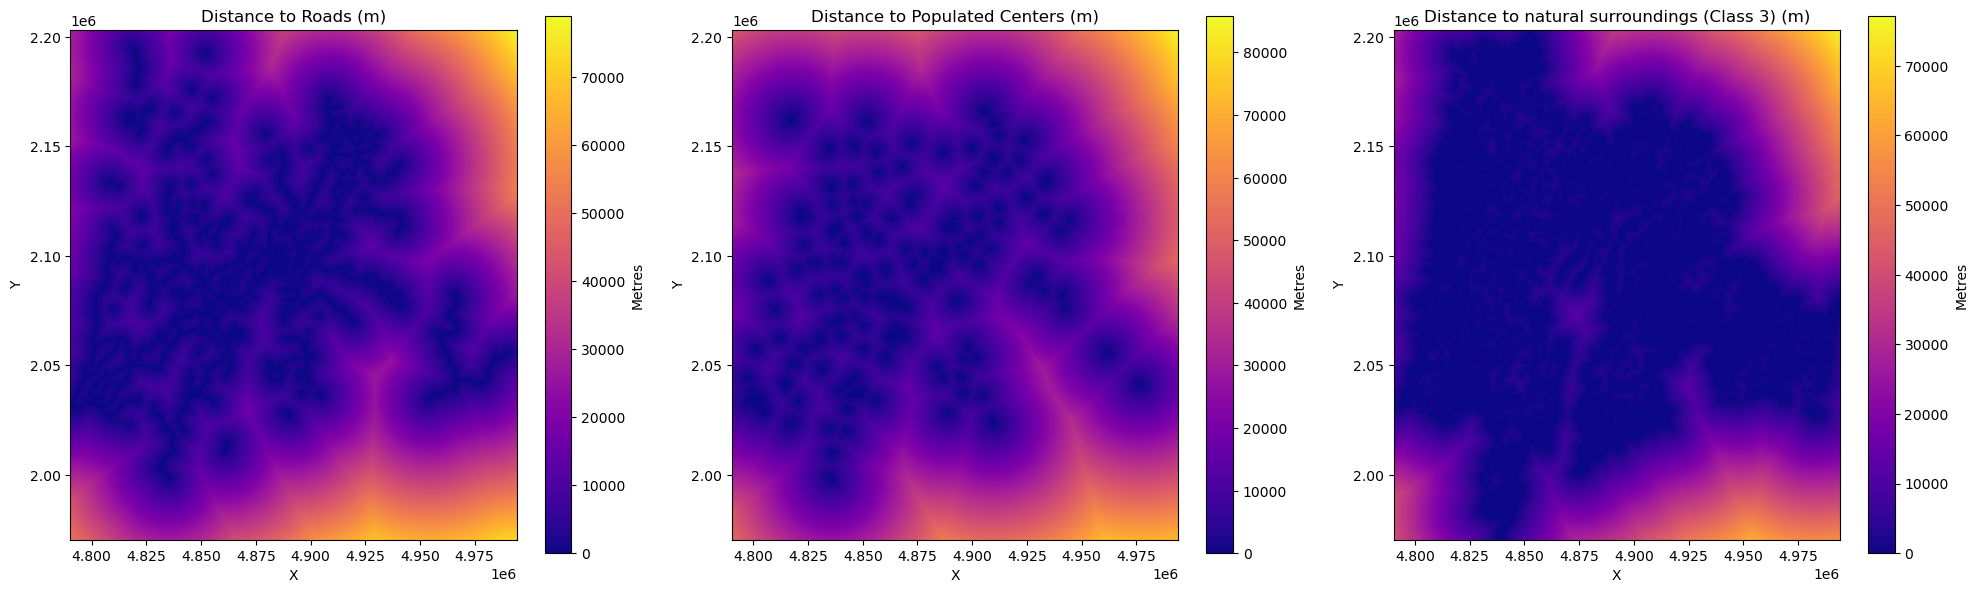

In [16]:
# Invert binary rasters (1 = feature → 0 for distance transform)
# distance_transform_edt computes distance TO the nearest zero
roads_inv = roads == 0
popcenter_inv = popcenter == 0

#  Compute Euclidean distance in pixels
dist_roads_px = distance_transform_edt(roads_inv)
dist_popcenter_px = distance_transform_edt(popcenter_inv)

# Extract binary mask for class 3 (Forests, and seminatural areas)
natural_surroundings_mask = (cover == 3).astype("uint8")

# Invert binary rasters (1 = feature → 0 for distance transform)
natural_surroundings_inv = natural_surroundings_mask == 0

#  Compute Euclidean distance in pixels
natural_surroundings_px = distance_transform_edt(natural_surroundings_inv)

#  Convert distances to map units using pixel size (assume square pixels)
pixel_size = transform[0]  # pixel width in map units (e.g., metres)
dist_roads_m = dist_roads_px * pixel_size
dist_popcenter_m = dist_popcenter_px * pixel_size
natural_surroundings_m = natural_surroundings_px * pixel_size


print("Euclidean distance rasters calculated in map units.")


# Visualization
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

img1 = axs[0].imshow(dist_roads_m, cmap='plasma', extent=[bounds.left, bounds.right, bounds.bottom, bounds.top])
axs[0].set_title("Distance to Roads (m)")
plt.colorbar(img1, ax=axs[0], label="Metres")

img2 = axs[1].imshow(dist_popcenter_m, cmap='plasma', extent=[bounds.left, bounds.right, bounds.bottom, bounds.top])
axs[1].set_title("Distance to Populated Centers (m)")
plt.colorbar(img2, ax=axs[1], label="Metres")

img3 = axs[2].imshow(natural_surroundings_m, cmap='plasma', extent=[bounds.left, bounds.right, bounds.bottom, bounds.top])
axs[2].set_title("Distance to natural surroundings (Class 3) (m)")
plt.colorbar(img3, ax=axs[2], label="Metres")

for ax in axs:
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.grid(False)

plt.tight_layout()
plt.show()

## Factor normalisation for Spatial Multi-Criteria Analysis (SMCA)

### Extracting raster extent from metadata

In [17]:
# Recompute extent from DEM metadata
xmin, ymax = dem_meta["transform"] * (0, 0)
xmax, ymin = dem_meta["transform"] * (dem_meta["width"], dem_meta["height"])
extent = [xmin, xmax, ymin, ymax]

### Normalisation criteria for suitability layers

#### **Slope (Cost Factor)**
- **Type:** Cost → lower slope is better  
- **Method:** Linear transformation  
  - 0% slope = 10 (most suitable)  
  - ≥20% slope = 0 (unsuitable)  

#### **Proximity to Roads and Populated Centers (Benefit Factor)**
- **Type:** Benefit → closer is better  
- **Method:** Linear transformation  
  - 0 m = 10 (most suitable)  
  - ≥2000 m = 0 (unsuitable)  

#### **Aqueduct and Sewerage Coverage (Benefit Factor)**
- **Type:** Benefit → higher values are better  
- **Method:** Linear transformation  
  - Value = 30 → 0 (unsuitable)  
  - Value = 80 → 10 (very suitable)  
  - Values ≤30 are considered unsuitable, ≥80 very suitable  

#### **Temperature (Benefit Factor)**
- **Type:** Benefit → higher values are better  
- **Method:** Linear transformation  
  - Value = 5 → 0 (unsuitable)  
  - Value = 10 → 10 (very suitable)  
  - Values ≤5 are considered unsuitable, ≥10 very suitable  

---

All resulting layers (`slope_norm`, `road_proximity_norm`, `river_proximity_norm`, etc.) are now on a **common scale (0–10)** and are ready for **weighted overlay in the Spatial Multi-Criteria Analysis (SMCA)** model.


In [18]:
slope_norm = normalise_slope_cost(slope, threshold=20.0)
print("✅ Slope normalised (0–10): >20% slope = not suitable (0)")
road_proximity_norm = normalise_proximity(dist_roads_m, threshold=2000)
print("✅ Road proximity normalised (0–10): closer = better (cut-off: 2000 m)")
porpulatecenter_proximity_norm = normalise_proximity2(dist_popcenter_m, threshold=10000)
print("✅ Populate center proximity normalised (0–10): closer = better (cut-off: 10 km)")
natural_surroundings_proximity_norm = normalise_proximity(natural_surroundings_m, threshold=2000)
print("✅ Natural surroundings proximity normalised (0–10): closer = better (cut-off: 2000 m)")
aqueduct_norm = normalise_aqueduct_sewer(acueduct)
print("✅ Aqueduct normalised (0–10): ≤30 = not suitable (0), ≥80 = highly suitable (10)")
sewer_norm = normalise_aqueduct_sewer(sewers)
print("✅ Sewer normalised (0–10): ≤30 = not suitable (0), ≥80 = highly suitable (10)")
climate_norm = normalise_climate(temp)
print("✅ Climate normalised (0–10): ≤5 = not suitable (0), ≥10 = highly suitable (10)")

✅ Slope normalised (0–10): >20% slope = not suitable (0)
✅ Road proximity normalised (0–10): closer = better (cut-off: 2000 m)
✅ Populate center proximity normalised (0–10): closer = better (cut-off: 10 km)
✅ Natural surroundings proximity normalised (0–10): closer = better (cut-off: 2000 m)
✅ Aqueduct normalised (0–10): ≤30 = not suitable (0), ≥80 = highly suitable (10)
✅ Sewer normalised (0–10): ≤30 = not suitable (0), ≥80 = highly suitable (10)
✅ Climate normalised (0–10): ≤5 = not suitable (0), ≥10 = highly suitable (10)


### Visual comparison of raw and normalised factors

Side-by-side visualisation of the original and normalised factor layers used in the spatial multicriteria analysis.

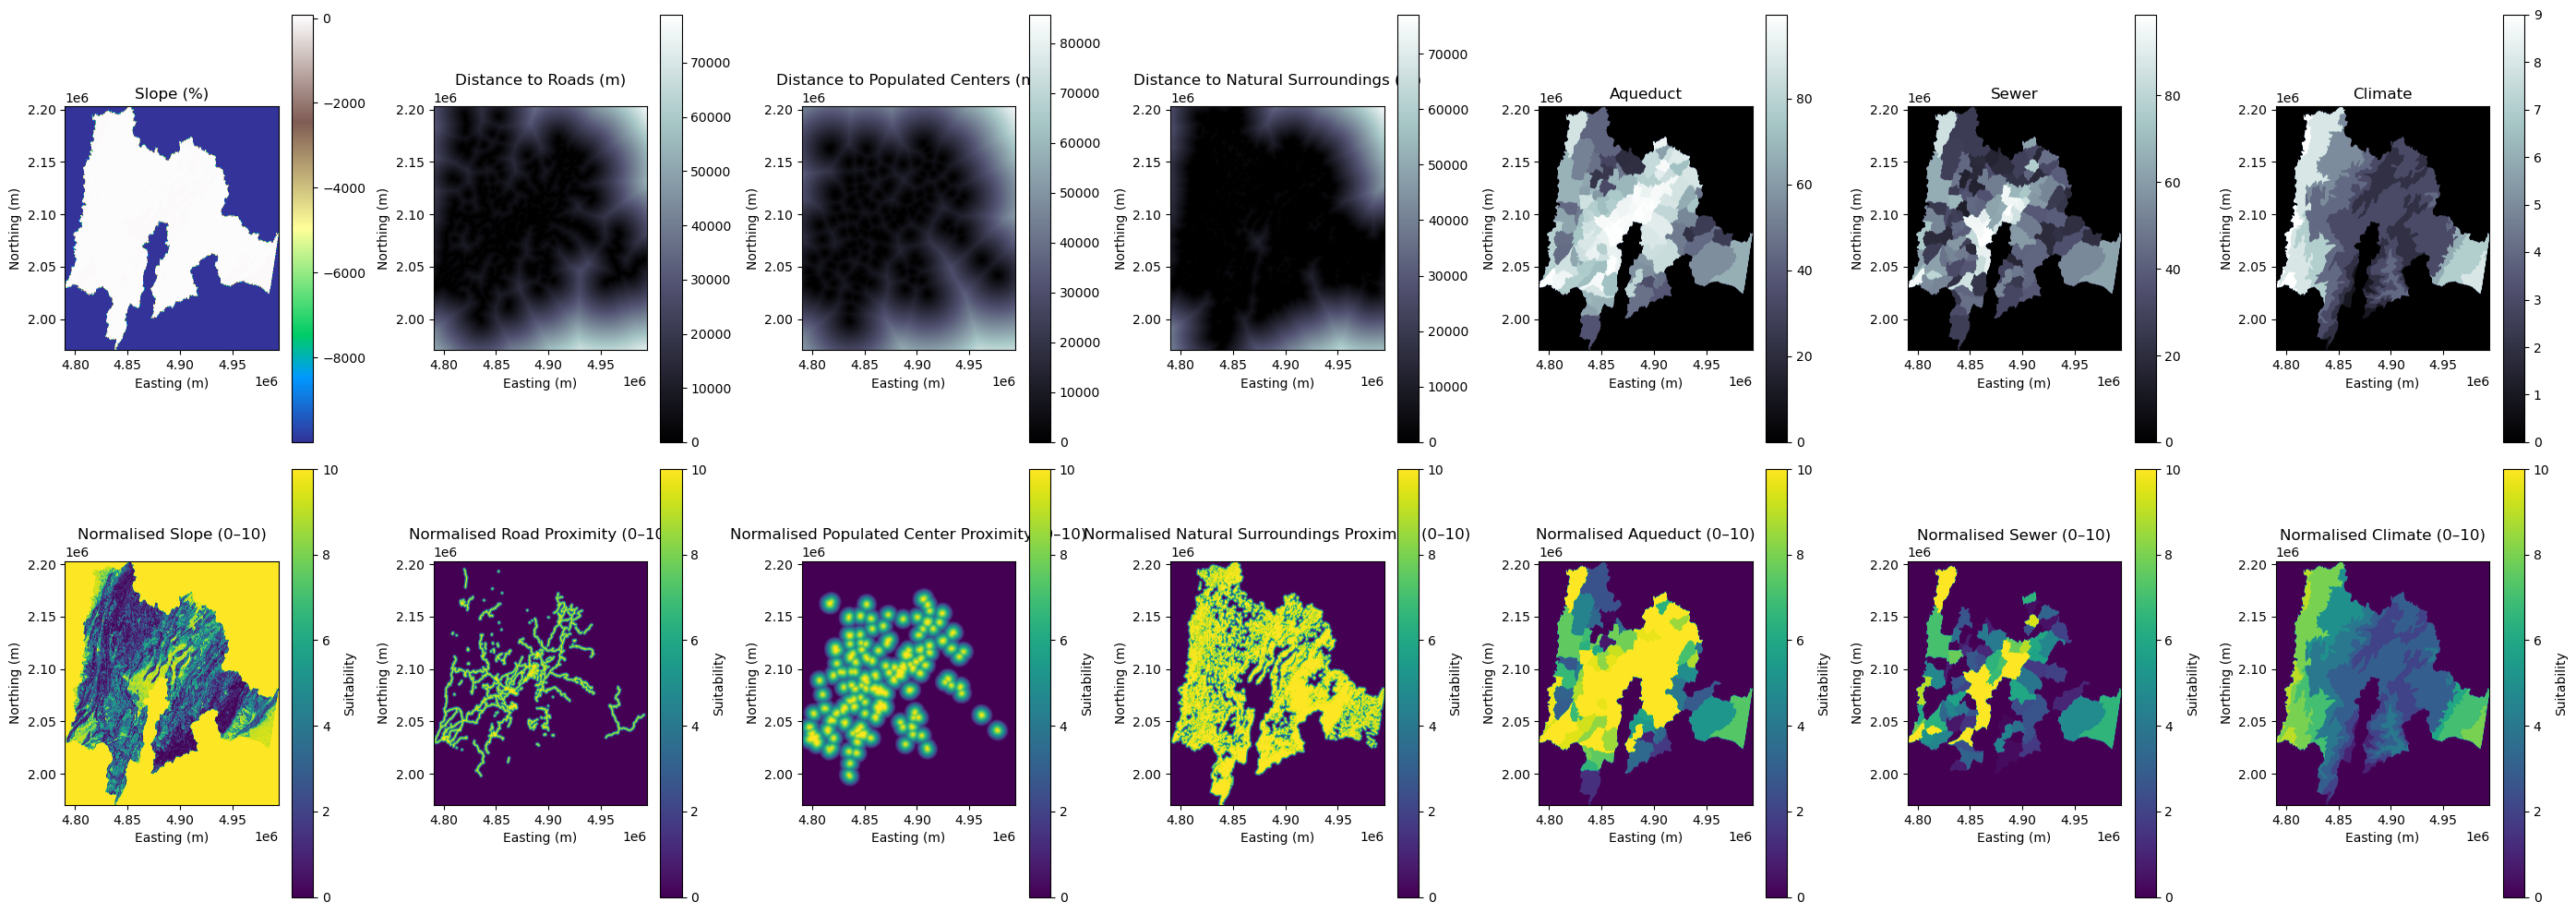

In [19]:

# Define a list of original (non-normalised) raster layers along with their titles for plotting
original_layers = [
    (slope, "Slope (%)"),
    (dist_roads_m, "Distance to Roads (m)"),
    (dist_popcenter_m, "Distance to Populated Centers (m)"),
    (natural_surroundings_m, "Distance to Natural Surroundings (m)"),
    (acueduct, "Aqueduct"),
    (sewers, "Sewer"),
    (temp, "Climate")
]

# Define the corresponding normalised layers (values scaled between 0–10) and their titles
norm_layers = [
    (slope_norm, "Slope (0–10)"),
    (road_proximity_norm, "Road Proximity (0–10)"),
    (porpulatecenter_proximity_norm, "Populated Center Proximity (0–10)"),
    (natural_surroundings_proximity_norm, "Natural Surroundings Proximity (0–10)"),
    (aqueduct_norm, "Aqueduct (0–10)"),
    (sewer_norm, "Sewer (0–10)"),
    (climate_norm, "Climate (0–10)")
]

# Create a figure with 2 rows and as many columns as there are layers, with custom size
fig, axs = plt.subplots(2, len(norm_layers), figsize=(4*len(norm_layers), 10))

# Plot the original layers in the top row (row index 0)
for i, (layer, title) in enumerate(original_layers):
    im = axs[0, i].imshow(
        layer, 
        cmap="bone" if i > 0 else "terrain",  # Use "terrain" for the first layer (slope), "bone" for the rest
        extent=extent, 
        origin="upper"
    )
    axs[0, i].set_title(title)
    axs[0, i].set_xlabel("Easting (m)")
    axs[0, i].set_ylabel("Northing (m)")
    plt.colorbar(im, ax=axs[0, i])  # Add a colorbar to each subplot

# Plot the normalised layers in the bottom row (row index 1)
for i, (layer, title) in enumerate(norm_layers):
    im = axs[1, i].imshow(
        layer, 
        cmap="viridis",               # Use consistent colormap for normalised data
        extent=extent, 
        origin="upper", 
        vmin=0, vmax=10               # Fixed range for suitability scores (0–10)
    )
    axs[1, i].set_title("Normalised " + title)
    axs[1, i].set_xlabel("Easting (m)")
    axs[1, i].set_ylabel("Northing (m)")
    plt.colorbar(im, ax=axs[1, i], label="Suitability")  # Colorbar with label

# Save the complete figure as a high-resolution PNG
plt.savefig("C:/Users/VICTUS/Documents/MG/programacion_sig/SMCA/results/normalised_rasters.png", dpi=300)
# Adjust subplot layout to prevent overlap
plt.tight_layout()
# Display the figure
plt.show()


## Restrictions

- This section generates a **combined restriction mask** to exclude unsuitable areas from the multicriteria analysis.
- The mask integrates four binary layers where a value of `1` indicates a restricted area:
  - **RUNAP**: Protected areas part of the National Natural Parks System.
  - **Indigenous Reserves**: Areas legally recognized as indigenous territories.
  - **Land Cover Class 5**: Represents water bodies land cover category.
  - **Mining Titles** (`min_raster`): Zones with mining concessions or activity.
- These layers are merged using a logical OR operation, resulting in a single binary mask (`restriction_mask`) where:
  - `1` = restricted (excluded from analysis),
  - `0` = allowed (candidate areas for suitability).
- A custom color map is applied (green = allowed, red = restricted) for intuitive visualization of overlapping restrictions.
- This map helps visually verify which areas are ruled out before performing further suitability modeling.


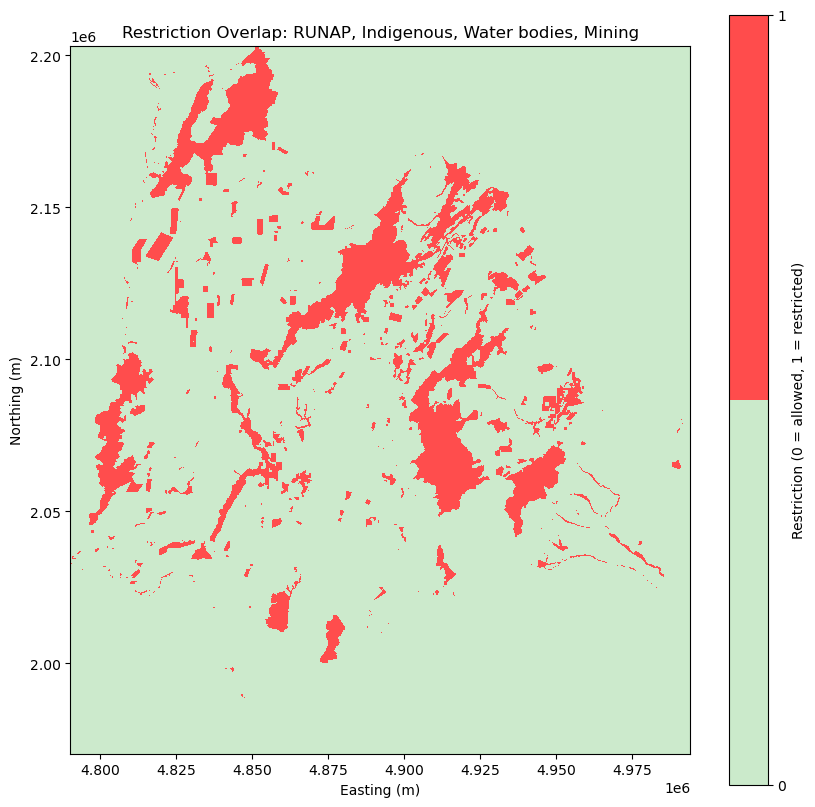

In [20]:
# Extract binary mask for class 5 (1 = class 5, 0 = others)
class5_mask = (cover == 5).astype("uint8")

# Invert for distance_transform_edt (1 = feature → 0 for distance computation)
class5_inv = class5_mask == 0

# Create binary restriction mask (1 = restricted)
# Assumes runap, indigenous, and min_raster are binary (1 = restriction)
restriction_mask = (
    (runap == 1) |
    (indigenous == 1) |
    (class5_mask == 1) |
    (min_raster == 1)
).astype("uint8")

from matplotlib.colors import ListedColormap

# Custom colormap: green = allowed (0), red = restricted (1)
custom_cmap = ListedColormap(["#b6e2b6", "red"])

plt.figure(figsize=(10, 10))
plt.imshow(restriction_mask, cmap=custom_cmap, alpha=0.7, extent=extent, origin="upper")
plt.title("Restriction Overlap: RUNAP, Indigenous, Water bodies, Mining")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(ticks=[0, 1], label="Restriction (0 = allowed, 1 = restricted)")
plt.show()


## Define normalised weight matrices for 3 perspectives

#### Weighted suitability calculation (7 factors)

Compute suitability maps based on different prioritization strategies using a **weighted linear combination** of seven normalized factors:

- **Slope**
- **Distance to roads**
- **Distance to populated centers**
- **Proximity to natural surroundings**
- **Access to aqueduct**
- **Access to sewerage**
- **Temperature**

#### Weighting Scenarios:
1. **Equal importance**: All seven criteria are considered equally important (1/7 weight each).
2. **Accessibility priority**: Emphasizes proximity to roads and populated centers (25% each).
3. **Services priority**: Prioritizes access to aqueduct, sewerage, and favorable climate (combined 60%).
4. **Nature areas priority**: Prefers zones near protected nature areas (40% for nature, and less for populated centers and roads)

Each weighting strategy reflects a different perspective or planning goal (balanced, infrastructure-focused, or service-driven).

#### Suitability Calculation:
- The `calculate_suitability7()` function combines the seven normalized layers using the defined weights.
- The output is a continuous raster with values ranging from 0 to 10, where higher values indicate greater suitability.

#### Restriction Application:
- Areas marked as restricted in the `restriction_mask` are assigned a value of `-1`, effectively excluding them from further consideration in the analysis.
- This step ensures that protected areas, mining zones, class 5 land cover, and indigenous territories are masked out from the final suitability maps.

> Final result: Three masked suitability maps corresponding to each prioritization scenario, ready for visualization or reclassification.


In [21]:
# 1. Equal importance — all seven factors contribute equally
weights_equal = {
    "slope": 1/7,
    "roads": 1/7,
    "popcenter": 1/7,
    "natural": 1/7,
    "aqueduct": 1/7,
    "sewer": 1/7,
    "climate": 1/7
}

# 2. Accessibility priority — roads and populated centers are most important
weights_access = {
    "slope": 0.10,
    "roads": 0.25,
    "popcenter": 0.25,
    "natural": 0.10,
    "aqueduct": 0.10,
    "sewer": 0.10,
    "climate": 0.10
}

# 3. Services priority — aqueduct, sewer, and climate are most important
weights_services = {
    "slope": 0.10,
    "roads": 0.10,
    "popcenter": 0.14,
    "natural": 0.10,
    "aqueduct": 0.23,
    "sewer": 0.23,
    "climate": 0.10
}

# 4. Nature areas priority — natural surroundings are most important

weights_nature = {
    "slope": 0.10,
    "roads": 0.05,
    "popcenter": 0.05,
    "natural": 0.40,
    "aqueduct": 0.10,
    "sewer": 0.10,
    "climate": 0.20
}


# Compute weighted suitability (0–10 scale) for each perspective

def calculate_suitability7(w, slope_n, roads_n, popcenter_n, natural_n, aqueduct_n, sewer_n, climate_n):
    """
    Calculate overall suitability score using weighted linear combination for 7 factors.
    """
    return (w["slope"] * slope_n +
            w["roads"] * roads_n +
            w["popcenter"] * popcenter_n +
            w["natural"] * natural_n +
            w["aqueduct"] * aqueduct_n +
            w["sewer"] * sewer_n +
            w["climate"] * climate_n)

suit_equal = calculate_suitability7(
    weights_equal,
    slope_norm, road_proximity_norm, porpulatecenter_proximity_norm,
    natural_surroundings_proximity_norm, aqueduct_norm, sewer_norm, climate_norm
)
suit_access = calculate_suitability7(
    weights_access,
    slope_norm, road_proximity_norm, porpulatecenter_proximity_norm,
    natural_surroundings_proximity_norm, aqueduct_norm, sewer_norm, climate_norm
)
suit_services = calculate_suitability7(
    weights_services,
    slope_norm, road_proximity_norm, porpulatecenter_proximity_norm,
    natural_surroundings_proximity_norm, aqueduct_norm, sewer_norm, climate_norm
)

suit_nature = calculate_suitability7(
    weights_nature,
    slope_norm, road_proximity_norm, porpulatecenter_proximity_norm,
    natural_surroundings_proximity_norm, aqueduct_norm, sewer_norm, climate_norm
)

# Apply restriction mask to exclude unsuitable zones
suit_equal_masked = np.where(restriction_mask == 1, -1, suit_equal)
suit_access_masked = np.where(restriction_mask == 1, -1, suit_access)
suit_services_masked = np.where(restriction_mask == 1, -1, suit_services)
suit_nature_masked = np.where(restriction_mask == 1, -1, suit_nature)

print("Weighted suitability maps (7 factors) calculated and masked (restricted zones = -1).")


Weighted suitability maps (7 factors) calculated and masked (restricted zones = -1).


### Visualization of weighted suitability maps with restrictions

Map the three weighted suitability (based on the defined prioritization strategies), incorporating the restriction mask.

#### Color Mapping:
- A **continuous red-to-green colormap**  is used to represent suitability:
  - **Red** = low suitability
  - **Green** = high suitability
- Restricted areas (value = `-1`) are shown in **gray** to clearly indicate zones excluded from analysis.
- A custom color map (`cmap_with_mask`) and normalization (`BoundaryNorm`) are used to blend the continuous scale with the discrete restricted value.

#### Map Panels:
- **Left**: Equal Importance — all factors weighted equally.
- **Center**: Accessibility Priority — emphasis on proximity to roads and populated centers.
- **Right**: Services Priority — prioritizes aqueduct, sewer, and climate.

Each panel includes:
- Axis labels and titles indicating the strategy used.
- A colorbar that clarifies the scale: `0–10` for suitability, and `gray` for restricted areas.

> This visualization allows for side-by-side comparison of how different weighting strategies affect spatial suitability outcomes.


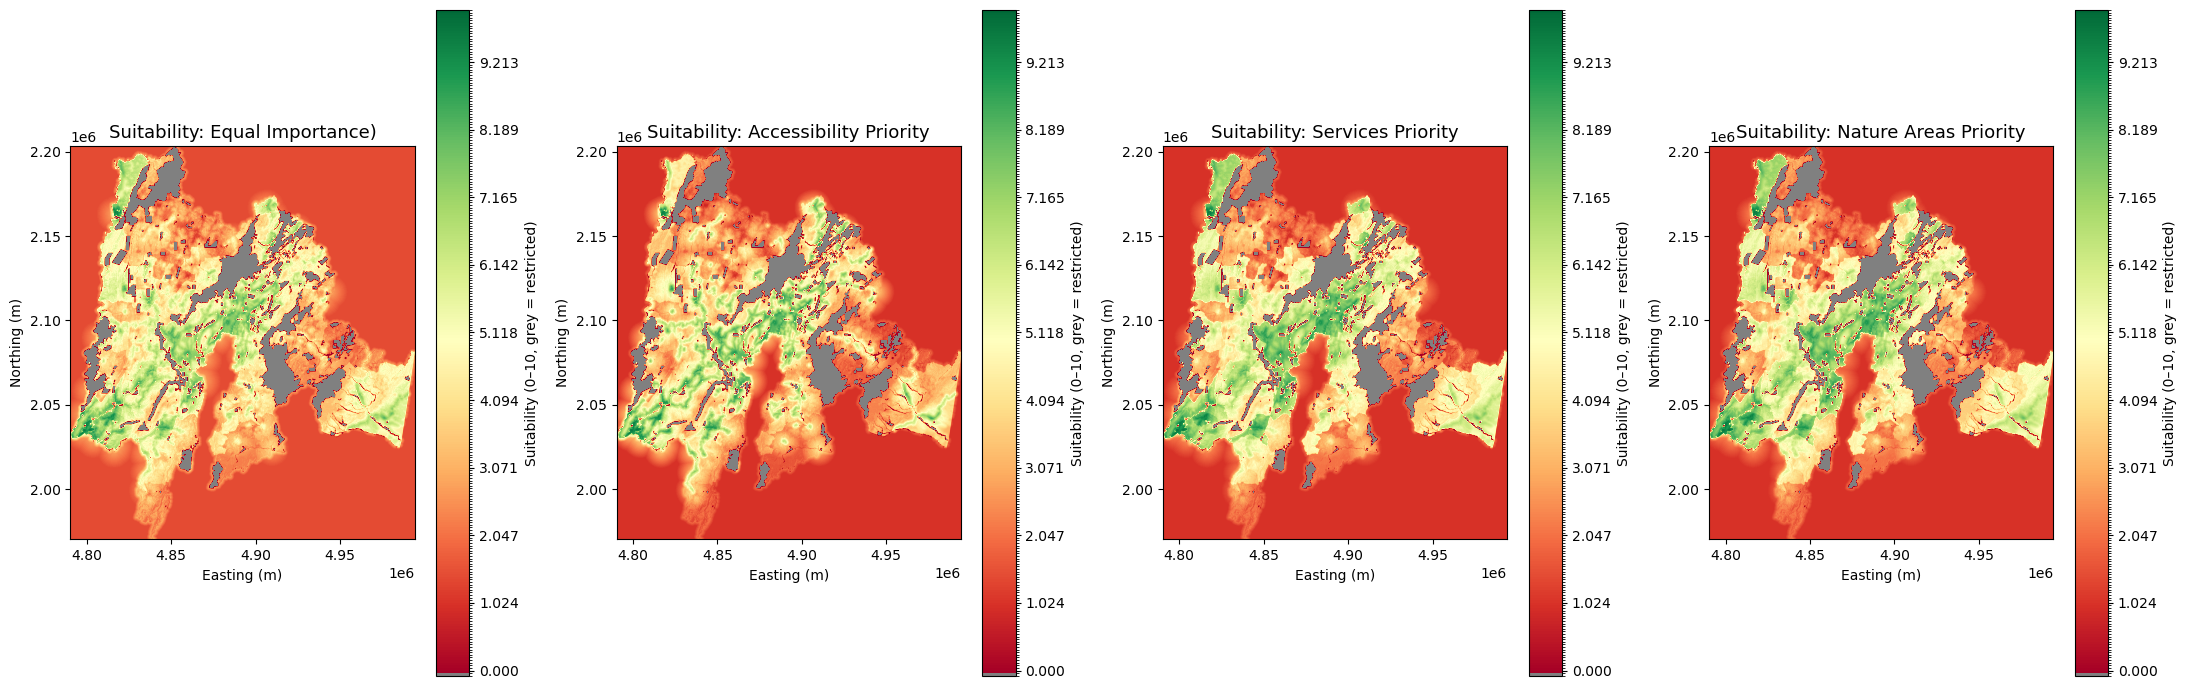

In [22]:
# Create a continuous red-green colormap with gray for restricted areas (-1)
base_cmap = plt.cm.RdYlGn
cmap_with_mask = mcolors.ListedColormap(['grey'] + [base_cmap(i) for i in range(base_cmap.N)])

# Define boundaries: -1 for restricted, then 0–10 for suitability
bounds = [-1.5, -0.5] + list(np.linspace(0, 10, base_cmap.N - 1))
norm = mcolors.BoundaryNorm(bounds, cmap_with_mask.N)

fig, axs = plt.subplots(1, 4, figsize=(22, 7))

# Perspective 1: Equal importance
im1 = axs[0].imshow(suit_equal_masked, cmap=cmap_with_mask, norm=norm, extent=extent, origin="upper")
axs[0].set_title("Suitability: Equal Importance)", fontsize=13)
axs[0].set_xlabel("Easting (m)")
axs[0].set_ylabel("Northing (m)")
plt.colorbar(im1, ax=axs[0], label="Suitability (0–10, grey = restricted)")

# Perspective 2: Accessibility priority
im2 = axs[1].imshow(suit_access_masked, cmap=cmap_with_mask, norm=norm, extent=extent, origin="upper")
axs[1].set_title("Suitability: Accessibility Priority", fontsize=13)
axs[1].set_xlabel("Easting (m)")
axs[1].set_ylabel("Northing (m)")
plt.colorbar(im2, ax=axs[1], label="Suitability (0–10, grey = restricted)")

# Perspective 3: Services priority
im3 = axs[2].imshow(suit_services_masked, cmap=cmap_with_mask, norm=norm, extent=extent, origin="upper")
axs[2].set_title("Suitability: Services Priority", fontsize=13)
axs[2].set_xlabel("Easting (m)")
axs[2].set_ylabel("Northing (m)")
plt.colorbar(im3, ax=axs[2], label="Suitability (0–10, grey = restricted)")

# Perspective 4: Nature areas priority
im4 = axs[3].imshow(suit_services_masked, cmap=cmap_with_mask, norm=norm, extent=extent, origin="upper")
axs[3].set_title("Suitability: Nature Areas Priority", fontsize=13)
axs[3].set_xlabel("Easting (m)")
axs[3].set_ylabel("Northing (m)")
plt.colorbar(im4, ax=axs[3], label="Suitability (0–10, grey = restricted)")

plt.tight_layout()
plt.savefig("C:/Users/VICTUS/Documents/MG/programacion_sig/SMCA/results/suitability.png", dpi=300)
plt.show()


### Visualization of the suitability maps with discrete categories


#### Classification Scheme:
The normalized suitability values (0–10) are reclassified into 3 qualitative levels:
- **1 (Low suitability)** → 0–3.3
- **2 (Medium suitability)** → 3.3–6.6
- **3 (High suitability)** → 6.6–10
- **0 (Restricted or 0 suitability)** → Remains gray to represent excluded areas (e.g., protected zones)

#### Colormap:
- `0 = grey` → Restricted
- `1 = red` → Low
- `2 = yellow` → Medium
- `3 = green` → High

#### Layout:
- Displays three side-by-side maps for the different weighting strategies:
  - Equal Importance
  - Accessibility Priority
  - Services Priority
- All maps share axis scales and a single, consistent color legend.
- A custom legend is added to the right side of the figure using color patches and class labels.

> This final map format is ideal for communication and interpretation, especially in reports or presentations, as it simplifies the visual comparison of spatial patterns.


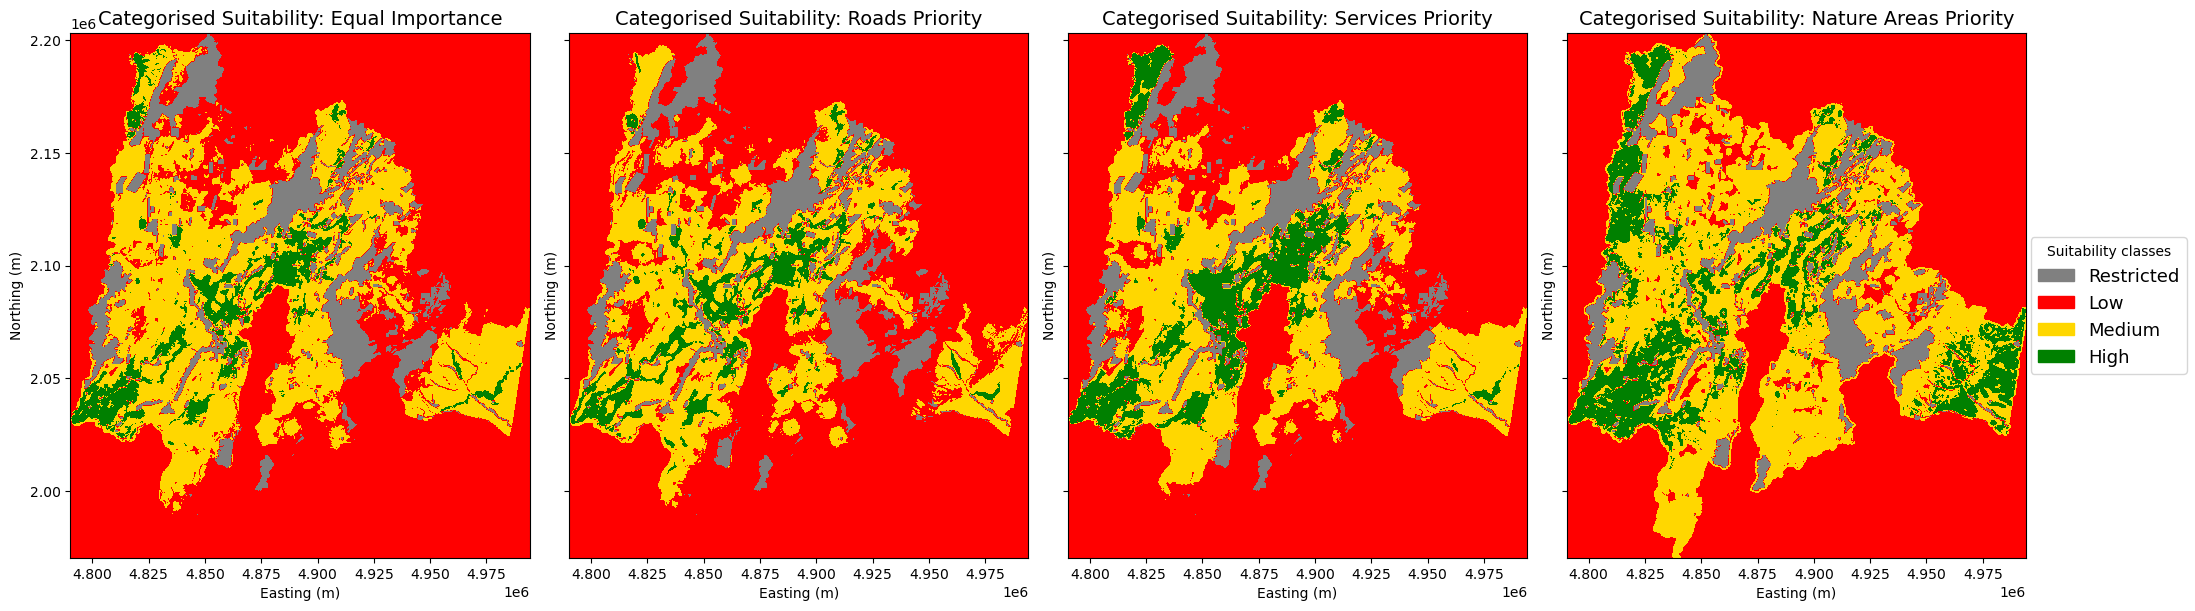

In [23]:
# Improved visualisation: classified suitability maps with shared legend and clearer layout
# 0 (restricted) is shown in grey

def classify_suitability(array_masked):
    """
    Classifies normalised suitability values (0–10) into 3 levels:
    1 = low, 2 = medium, 3 = high. Restricted zones (-1 or 0) remain as 0 (grey).
    """
    classified = np.full_like(array_masked, 0)
    classified[(array_masked > 0) & (array_masked <= 3.3)] = 1
    classified[(array_masked > 3.3) & (array_masked <= 6.6)] = 2
    classified[(array_masked > 6.6)] = 3
    # Ensure both -1 and 0 are shown as grey
    classified[array_masked <= 0] = 0
    return classified

# Apply to the 3 perspectives
suit_equal_class = classify_suitability(suit_equal_masked)
suit_roads_class = classify_suitability(suit_access_masked)
suit_slope_class = classify_suitability(suit_services_masked)
suit_nature_class = classify_suitability(suit_nature_masked)

# Define colours: 0 = grey, 1 = red, 2 = yellow, 3 = green
class_cmap = ListedColormap(["grey", "red", "gold", "green"])
class_labels = ["Restricted", "Low", "Medium", "High"]
boundaries = [-0.5, 0.5, 1.5, 2.5, 3.5]
norm = BoundaryNorm(boundaries, class_cmap.N)

fig, axs = plt.subplots(1, 4, figsize=(22, 8), sharex=True, sharey=True)

titles = [
    "Categorised Suitability: Equal Importance",
    "Categorised Suitability: Roads Priority",
    "Categorised Suitability: Services Priority",
    "Categorised Suitability: Nature Areas Priority"
]
classified_maps = [suit_equal_class, suit_roads_class, suit_slope_class, suit_nature_class]

for i, (ax, data, title) in enumerate(zip(axs, classified_maps, titles)):
    im = ax.imshow(data, cmap=class_cmap, norm=norm, extent=extent, origin="upper")
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Northing (m)")
    ax.grid(False)

# Shared legend (right side)
from matplotlib.patches import Patch
legend_patches = [Patch(color=class_cmap(i), label=label) for i, label in enumerate(class_labels)]
fig.legend(handles=legend_patches, loc='center right', title="Suitability classes", fontsize=13)

plt.tight_layout(rect=[0, 0, 0.93, 1])
plt.savefig("C:/Users/VICTUS/Documents/MG/programacion_sig/SMCA/results/suitabilty_categorised.png", dpi=300)
plt.show()

## Conclusion

This multicriteria analysis evaluated land suitability for living in Cundinamarca using seven geospatial factors: slope, accessibility (roads and populated centers), proximity to natural surroundings, aqueduct and sewerage coverage, and climate. Four weighting strategies were applied to reflect different lifestyles priorities: equal importance, accessibility-focused, service-focused, and nature areas-focused.

After applying a restriction mask to exclude protected areas (RUNAP), indigenous territories, mining zones, and unsuitable land cover (class 5), the final suitability maps revealed the following insights:

- High suitability zones consistently appear in flat to gently sloped areas with good access to infrastructure and services, primarily in the central and western parts of Cundinamarca, near Bogotá and major municipalities.  

- Low suitability areas are typically found in mountainous regions, remote zones with limited infrastructure, or areas under legal restrictions.  

- Weighting scenarios matter: prioritizing accessibility highlights suitability near roads and towns, while the services-focused approach favors zones with water and sanitation coverage.